## 0. Import packages

In [107]:
import xarray as xr
import numpy as np
from sklearn.cluster import DBSCAN, OPTICS, HDBSCAN, KMeans
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import matplotlib as mpl
import cartopy.crs as ccrs
import cmocean

## 1. Import data 

In [123]:
dataset= xr.open_dataset('/Users/1614576/Documents/GitHub/Lagrangian_diags/Simulations/toy_data_01.nc')

time_index=118
time= dataset.time.isel(obs=time_index).values[0]
ds=dataset.isel(obs=time_index)

## 2. Define & apply clustering algorithms

In [83]:

clustering_dict={ 
    'K-means': {'algorithm': KMeans(n_clusters=10)},
    'DBSCAN':  {'algorithm': DBSCAN(eps=np.radians(0.3), min_samples=5,  metric='haversine', algorithm='ball_tree')},
    'OPTICS':  {'algorithm': OPTICS(min_samples= 10, metric='haversine', algorithm='ball_tree', max_eps=np.radians(2))}, 
}

In [84]:
def cluster(ds, algorithm, algorithm_name):
    points = np.column_stack([np.radians(ds.lon.values), np.radians(ds.lat.values)])
    clustering =algorithm.fit(points)
    labels = clustering.labels_
    unique_labels = np.where(labels == -1, -1, labels )

    if algorithm_name=='OPTICS': 
        reachability_values = np.full(len(ds.lon.values), np.nan)
        reachability_values[clustering.ordering_] = clustering.reachability_[clustering.ordering_]

        ordering_values = np.full(len(ds.lon.values), -1)  # Initialize with -1
        for order_pos, orig_idx in enumerate(clustering.ordering_):
            ordering_values[orig_idx] = order_pos  # Store ordering position for each original point
            
        core_values=clustering.core_distances_
        
        
    else:
        reachability_values=np.full_like(unique_labels, 0)
        ordering_values=np.full_like(unique_labels, 0)
        core_values=np.full_like(unique_labels, 0)
        
    df_cluster = pd.DataFrame({
        'traj_index': ds.traj.values,
        'lon': ds.lon.values,
        'lat': ds.lat.values,
        'cluster_label': unique_labels,
        'is_noise': (labels == -1),
        'reachability': reachability_values,
        'ordering': ordering_values,
        'core_distances': core_values,
})
    
    return df_cluster

In [85]:
for clustering_method in tqdm(clustering_dict):
    print(clustering_method)
    algorithm= clustering_dict[clustering_method]['algorithm']
    clustering_dict[clustering_method]['result']= cluster(ds, algorithm, clustering_method)

100%|██████████| 3/3 [00:00<00:00, 80.79it/s]

K-means
DBSCAN
OPTICS


## 3. Visualise results

  0%|          | 0/3 [00:00<?, ?it/s]

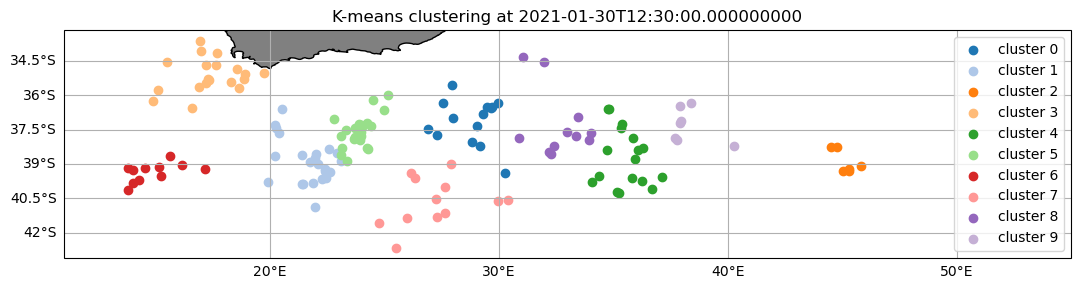

 33%|███▎      | 1/3 [00:00<00:00,  7.05it/s]

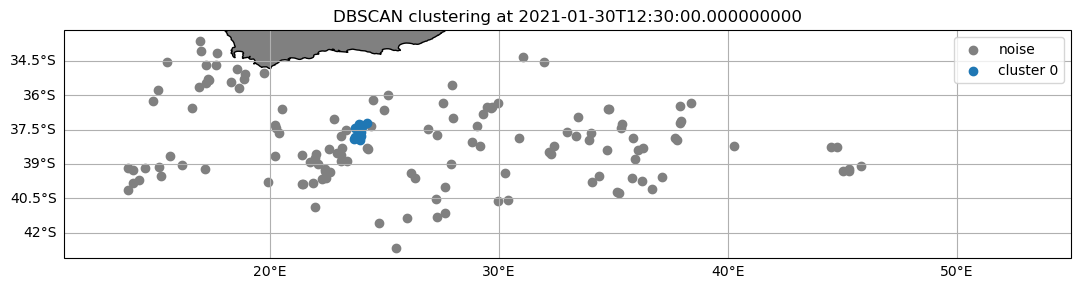

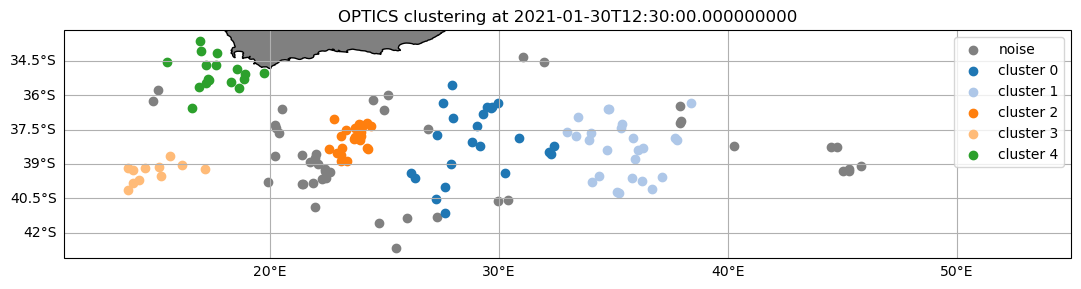

100%|██████████| 3/3 [00:00<00:00,  8.96it/s]


In [124]:
for clustering_method in tqdm(clustering_dict):
    df=clustering_dict[clustering_method]['result']

    fig=plt.figure(figsize=(13,6)) 
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0.0))

    #plot coastlines
    ax.coastlines(resolution='10m')
    ax.add_feature(cartopy.feature.LAND, facecolor='grey')

    #draw grid lines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False


    if -1 in np.unique(df['cluster_label']):
        noise_df= df[df['cluster_label']==-1]
        label_df=df[df['cluster_label']!=-1]
        ax.scatter(noise_df['lon'], noise_df['lat'], c='grey', label='noise')
    
    else:
        label_df= df

    colors = mpl.colormaps['tab20'].colors

    for i, elem in enumerate(np.unique(label_df['cluster_label'])):
        a=label_df[label_df['cluster_label']==elem]
        ax.scatter(a['lon'], a['lat'],  color=colors[i], label=f'cluster {elem}')
    
    plt.legend()
    ax.set_xlim(11, 55)
    plt.title(f'{clustering_method} clustering at {time}')
    plt.show()